<img src='http://linked.earth/FROGS/images/Pyrateslogo.jpg' width="400">

# Chapter 4: Spectral Analysis

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), University of Southern California


Recall that in spectral analysis we step into a "bizarro world", switching from the time domain to the frequency domain. There,  two essential features are of interest: peaks, and background. In this tutorial, we will perform spectral analysis on Rio Grande streamflow, and see if we can learn anything interesting about it in this way.

### Packages
In addition to the Scientific Python stack (numpy, scipy, matplotlib), this tutorial showcases: 
- [pandas](https://pandas.pydata.org/)
- [Pyleoclim](http://linked.earth/PyleoTutorials/) was designed for the analysis of paleoclimate timeseries, but we show here that is perfectly able to deal with any timeseries.

### Dataset    
We will be looking at the daily discharge of the Rio Grande, which has been measured at 
Embudo, NM since 1889. The data and their associated metadata may be retrieved from
the [USGS website](https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=html&site_no=08279500&legacy=&referred_module=sw&period=&begin_date=2023-05-21&end_date=2024-05-20
). Let's load them and have a look:

## Data Wrangling 

Once again we use pandas to load the data from the web. We need to give it a little help by specifying the column names:

In [152]:
import pandas as pd
url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=08279500&legacy=&referred_module=sw&period=&begin_date=1889-01-01&end_date=2024-05-20'

df = pd.read_csv(url, header=30, sep='\t', names=['agency', 'site_no', 'datetime','discharge (cf/s)','code'])
df.head()

,agency,site_no,datetime,discharge (cf/s),code
0,USGS,8279500,1889-01-01,398.0,A
1,USGS,8279500,1889-01-02,385.0,A
2,USGS,8279500,1889-01-03,395.0,A
3,USGS,8279500,1889-01-04,400.0,A
4,USGS,8279500,1889-01-05,413.0,A


the fourth column is the one we want, and we'll want to use the datetime column as a index for pandas. Let us create a new pandas Series from this dataframe, with this new and improved index:

In [48]:
date = pd.to_datetime(df['datetime'])
dis = df['discharge (cf/s)']
dis.index = date
dis

datetime
1889-01-01     398.0
1889-01-02     385.0
1889-01-03     395.0
1889-01-04     400.0
1889-01-05     413.0
               ...  
2024-05-16    1000.0
2024-05-17    1020.0
2024-05-18    1030.0
2024-05-19    1150.0
2024-05-20    1280.0
Name: discharge (cf/s), Length: 49448, dtype: float64

First, let us inspect the distribution of values:

<Axes: >

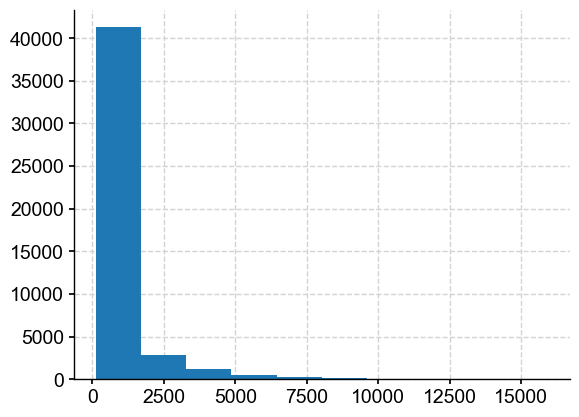

In [208]:
dis.hist()

Like many other variables, streamflow is **positively skewed**: the distribution is asymmetric, with most values near zero and few instances of very high streamflow. Now let's inspect the temporal behavior:

<Axes: xlabel='datetime'>

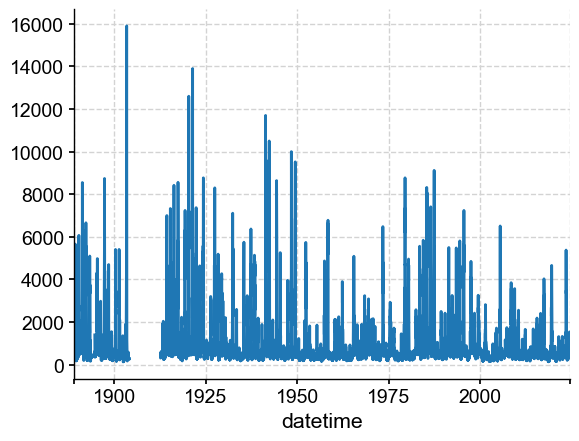

In [49]:
dis.plot()

We see that there is a large gap in the dataset, which could complicate analysis. Overall, a significant percentage of values are missing (coded as NaNs). We can estimate that percentage as follows, using pandas's `isna()`: 

In [42]:
dis.isna().sum()/len(dis)*100

6.651431807150947

This is no problem for Pyleoclim, which is built to handle missing values, even large gaps like the one in the 1910s. 
However, daily data are a lot! Let's resample to a monthly interval to lighten up calculations a bit:

<Axes: xlabel='datetime'>

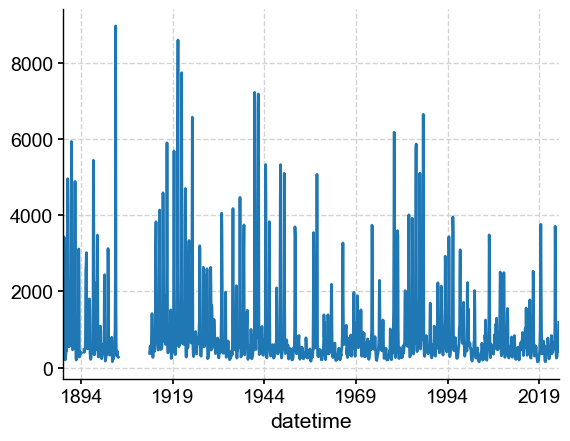

In [220]:
dis_c = dis.resample('M').mean()
dis_c.plot()


### Conversion to Pyleoclim

Having loaded and inspected the data, we are ready to start analyzing it. We do so via the `Pyleoclim` package.
Here we show one way to ingest the `pandas` Series object into a `Pyleoclim` Series object. In addition to `dis_c`, we need a little bit of metadata:

In [221]:
metadata = {
        'time_unit': 'years CE',
        'time_name': 'Time',
        'value_unit': 'cf/s',
        'value_name': 'discharge',
        'label': 'Rio Grande at Embudo, NM (monthly)',
        'archiveType': 'Instrumental',
        'importedFrom': 'USGS',
    }

In [222]:
import pyleoclim as pyleo
ts = pyleo.Series.from_pandas(ser=dis_c,metadata=metadata)
ts

{'archiveType': 'Instrumental',
 'importedFrom': 'USGS',
 'label': 'Rio Grande at Embudo, NM (monthly)'}


None
Time [years CE]
1889.086207     432.548387
1889.162869     472.607143
1889.247744     781.483871
1889.329881    2259.666667
1889.414756    3430.645161
                  ...     
2024.084299     413.967742
2024.163699     494.068966
2024.248574     573.451613
2024.330711     875.900000
2024.415586    1190.000000
Name: discharge [cf/s], Length: 1625, dtype: float64

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='discharge [cf/s]'>)

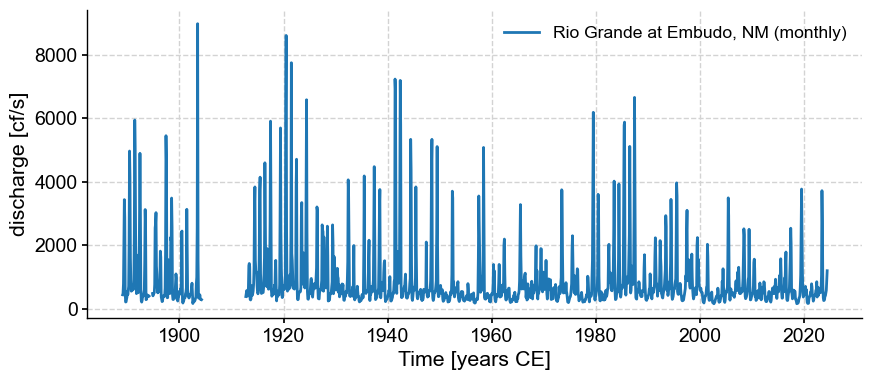

In [223]:
ts.plot()

There seem to be two segments. Let's see what Pyleoclim makes of them:

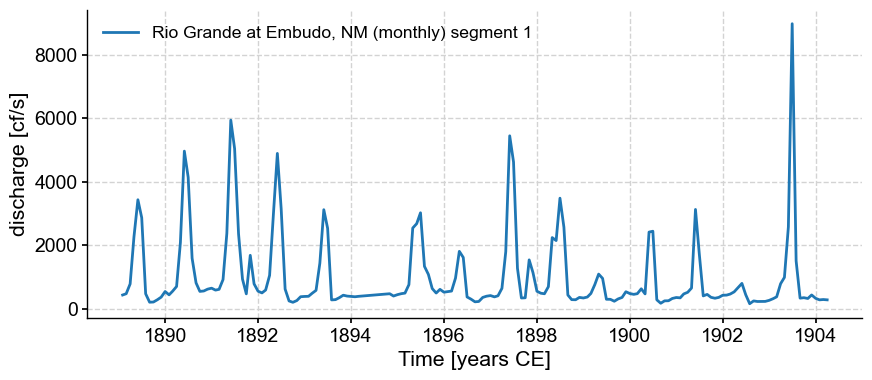

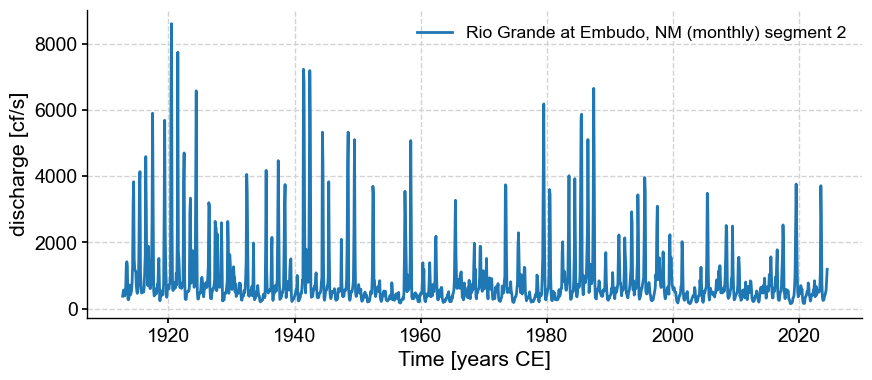

In [212]:
ms = ts.segment()
for s in ms.series_list:
    s.plot()

Note that despite our monthly resampling, the series are not actually evenly spaced:

(<Figure size 1100x800 with 2 Axes>,
 {'res': <Axes: xlabel='Time [years CE]', ylabel='resolution [years CE]'>,
  'res_hist': <Axes: xlabel='Counts'>})

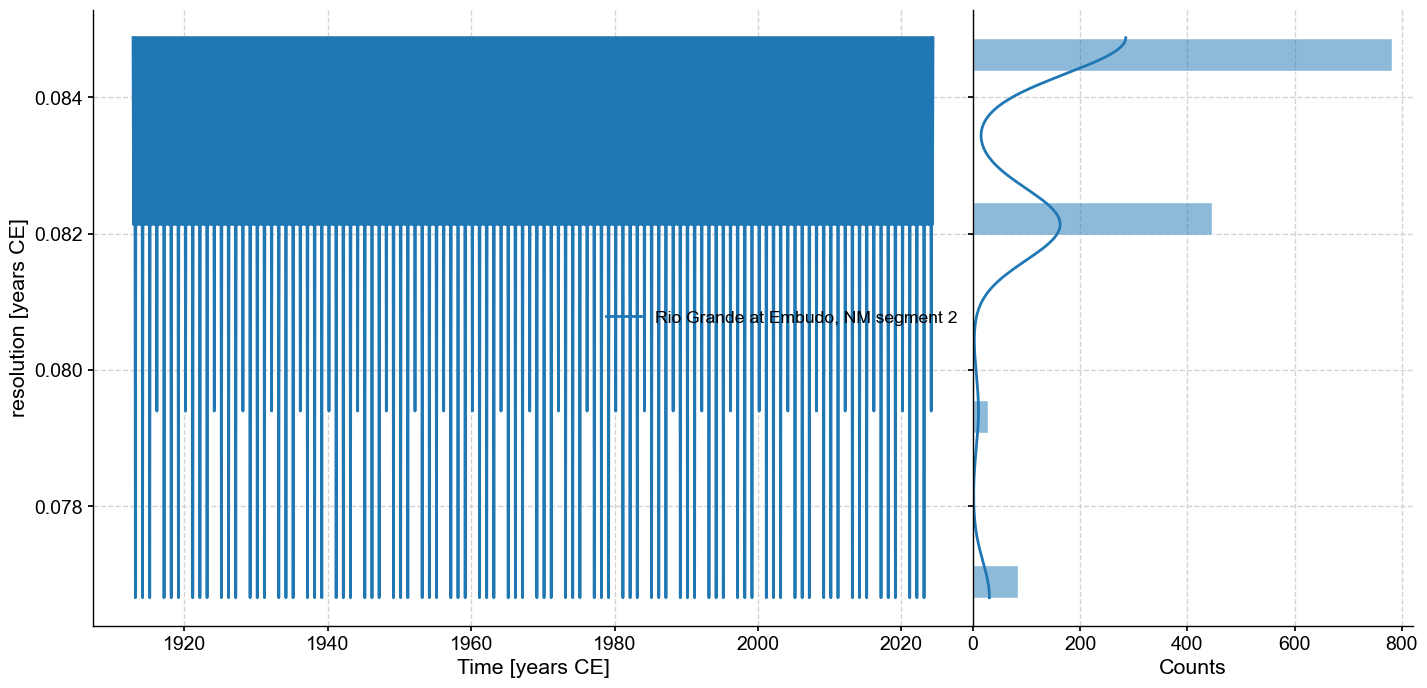

In [162]:
ts_late.resolution().dashboard()

Recall that most timeseries methods assume **even spacing** (no gaps). We have two options: apply dedicated gap-tolerant spectral methods, or find away to fill the gaps so that we can apply classical techniques that assume even spacing. 


## Gap-free analysis
Let us focus on the last segment for our analysis. Let's use the `spectral()` method and select the multi-taper method (MTM)

In [213]:
ts_late = ms.series_list[1]
psd = ts_late.standardize().spectral(method='mtm')
psd.plot()

ValueError: For the MTM method, data should be evenly spaced

Here we got reprimanded for passing an unevenly-spaced series to a method that expects even spacing. Never mind; we can interpolate to a monthly sampling:

<Axes: xlabel='Time [years CE]', ylabel='discharge [cf/s]'>

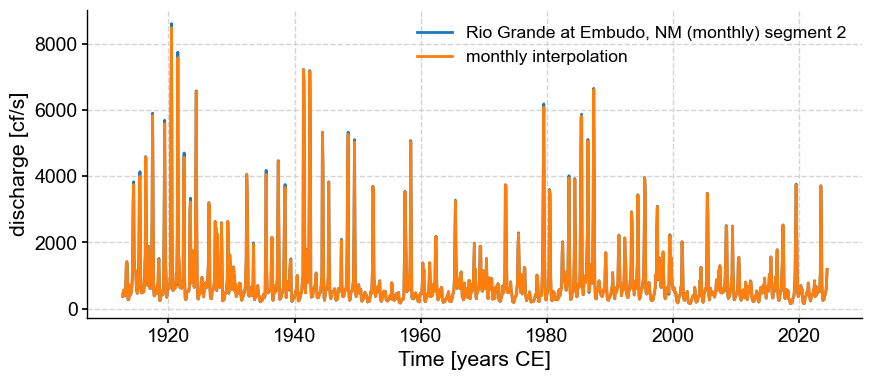

In [214]:
tsi = ts_late.interp(step=1/12) # note the step of 1/12, as the time has units of years
fig, ax = ts_late.plot()
tsi.plot(ax=ax, label = 'monthly interpolation')

We can see that the results are very close. Now let us apply MTM to the interpolated series:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

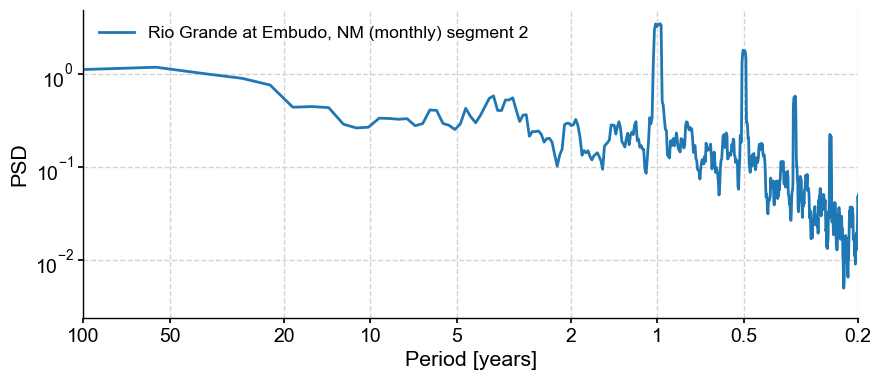

In [215]:
psd_mtm = tsi.spectral(method='mtm')
psd_mtm.plot()


The prominent feature is a strong annual cycle and higher-order harmonics, super-imposed on a "warm colored" background (i.e. variations at long timescales are larger than variations at short timescales). There are hints of long-term scaling as well, one in the subannual range, and one from period of 1 to 50y. 
We may be interested in the shape of this background, and whether it can be fit by one or more power laws. 

In addition, we may be interested in interannual (year-to-year) to interdecadal (decade-to-decade) variations in streamflow. We would like to know whether the peak observed around 3-4 years in the plot above is **significant** with respect to a reasonable null.  

To do both of these things it would make sense to remove the annual cycle. There are several options to do so:
- STL decomposition (see Intro notebook)
- calculating and removing the monthly-mean seasonal cycle

To apply STL, we need to get back into pandas land. Thankfully, `Pyleoclim` has utilities that make interconversion with pandas a breeze. Let's return to our monthly-sampled dataframe, but only select the indices that correspond to the late segment identified by `Pyleoclim`:

<Axes: xlabel='datetime'>

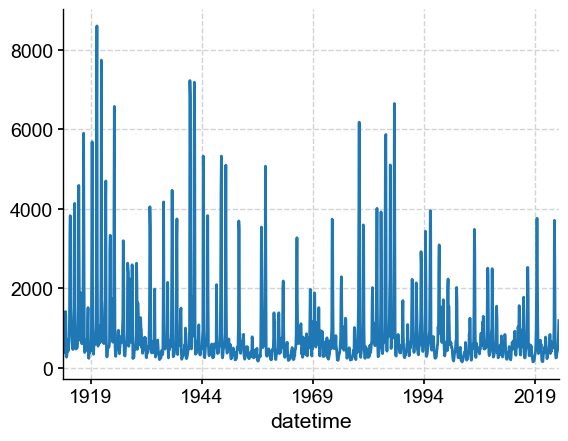

In [165]:
dis_late = dis_c.loc[dis_c.index > ts_late.to_pandas().index.min()] # select the last segment of the dataframe
dis_late.plot()

Now, because of the positive skew mentioned above, it turns out that the STL decomposition has trouble with this dataset. Instead, we can use the [gaussianize()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.gaussianize) to map this dataset to a standard normal. There are applications for which this would be undesirable, but for this purpose it is good:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='discharge [cf/s]'>)

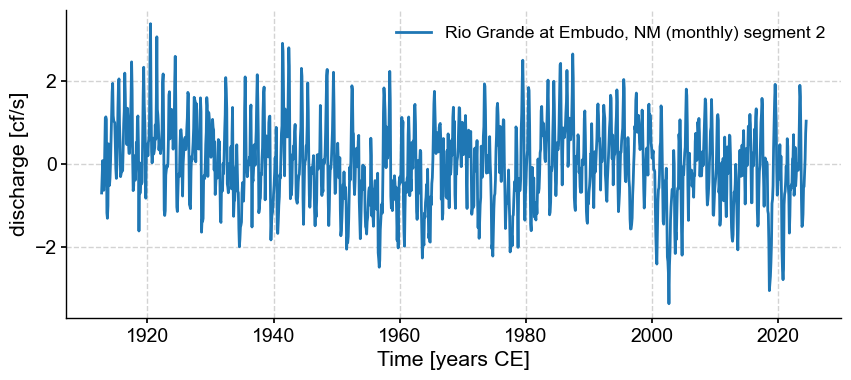

In [216]:
ts_lg = tsi.gaussianize()
ts_lg.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

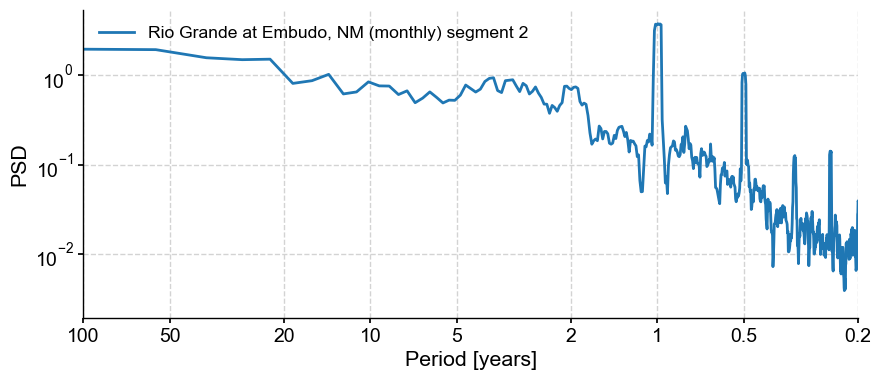

In [217]:
ts_lg.spectral(method='mtm').plot()

We see that the spectrum is nearly unchanged, but now we can apply STL:

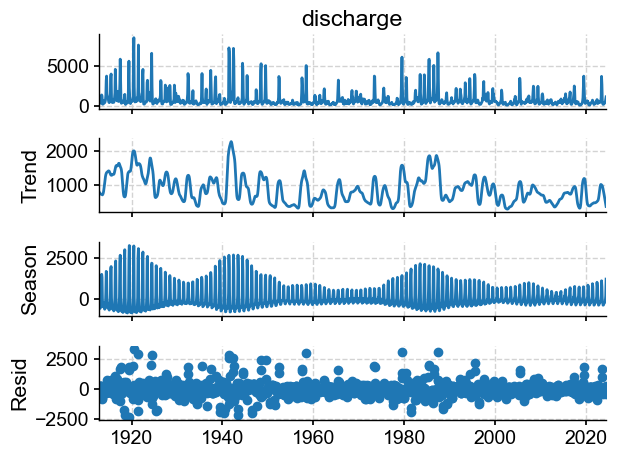

In [231]:
from statsmodels.tsa.seasonal import STL
dis_m = tsi.to_pandas().resample('M').nearest()
stl = STL(dis_m, seasonal=13)
stl_res = stl.fit()
fig = stl_res.plot()

Let's turn this into a `Pyleoclim` series and apply spectral analysis

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='discharge [cf/s]'>)

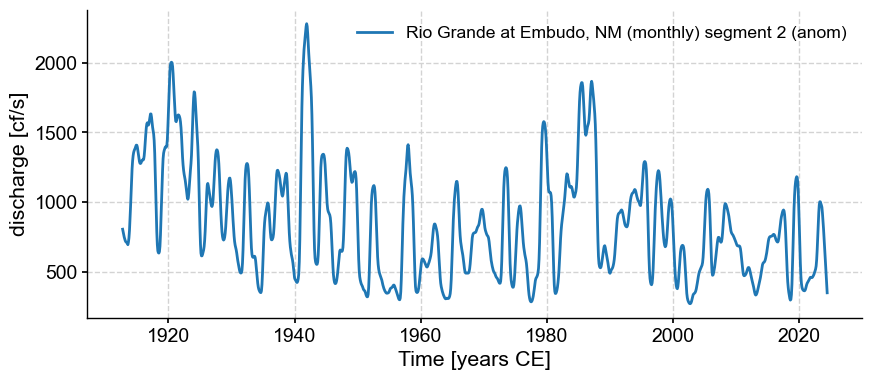

In [232]:
anom = pyleo.Series.from_pandas(stl_res.trend,metadata)
anom.label = tsi.label + ' (anom)'
anom.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

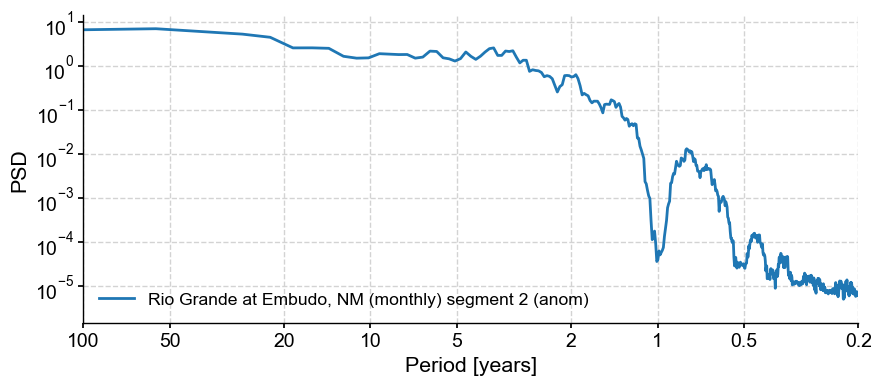

In [233]:
psd_a = anom.interp().spectral(method='mtm')
psd_a.plot()

Indeed this removed the annual cycle and its harmonics (for the most part). It's a fairly aggressive treatment, but 
we can now test the significance of the interannual peaks w.r.t to an AR(1) benchmark. 

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:42<00:00, 23.41it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

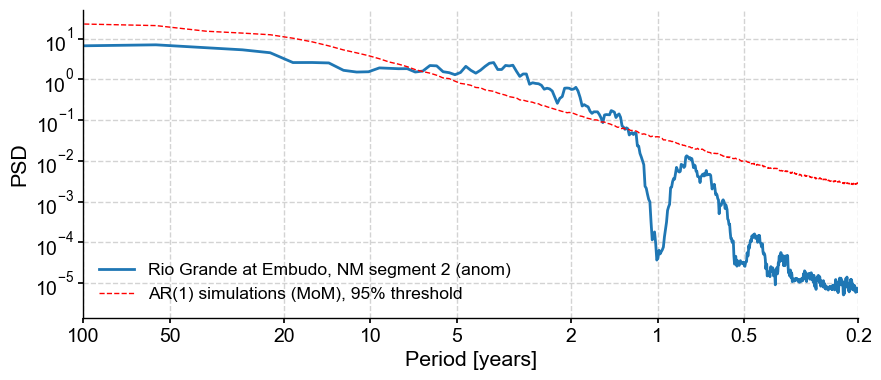

In [201]:
psd_ar1 = psd_a.signif_test(method='ar1sim',number=1000)
psd_ar1.plot()

Note that we specified 1,000 surrogates to be used for this assessment of significance. The default is 200, but that is too few for research-grade applications, and certainly for publication. 

If you wanted a colored-noise (power-law) benchmark instead, you would invoke it via the `method` argument:

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

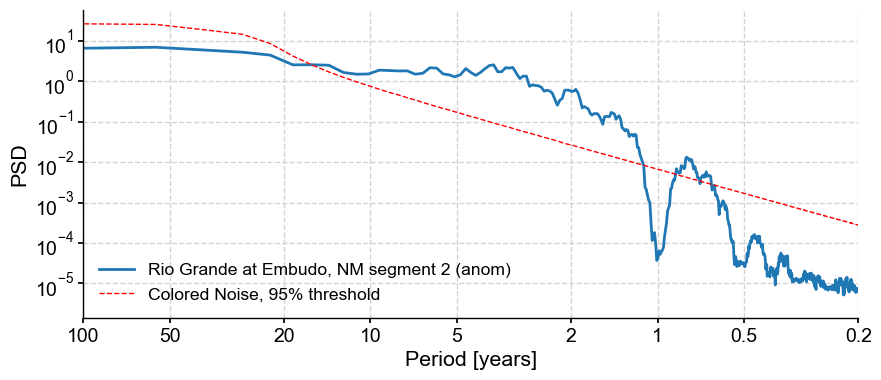

In [202]:
psd_cn = psd_a.signif_test(method='CN',number=1000)
psd_cn.plot()

We see that in both types of surrogates, the broadband peak in the 2-10y range is above the 95% threshold, so these frequencies could be considered significant. 

## Estimation of scaling behavior
In this last example, `Pyleoclim` fit a single scaling exponent to the timeseries, spanning the entire range of frequencies(periods). Under the hood, all we are doing is fitting a straight line to the spectrum:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

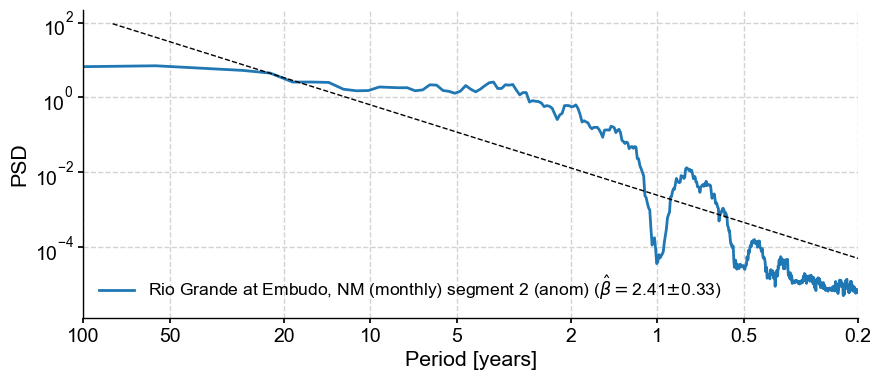

In [239]:
psd_a.beta_est().plot()

This results in a fairly steep exponent near 2.4. If we were specifically interested in the scaling exponent (spectral slope) between periods of 2-100y, you would do it like so:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

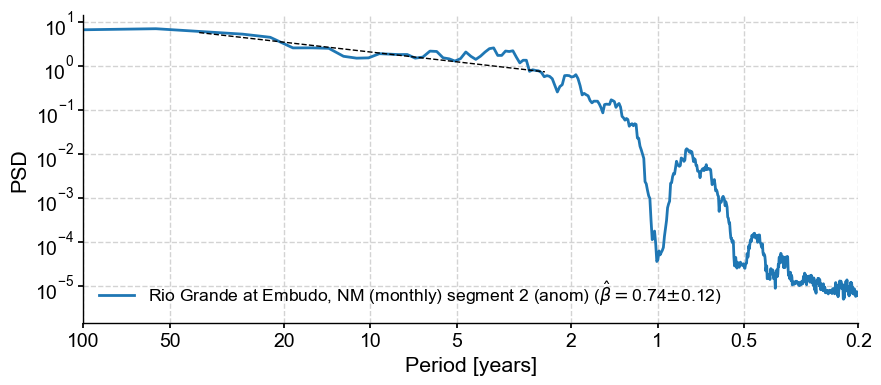

In [238]:
psd_a.beta_est(fmin=1/100, fmax=1/2).plot()

We see that this results in a much flatter line, i.e. a smaller scaling exponent around 0.75

## Gap-tolerant spectral analysis
We return to the original series and apply 2 techniques to obtain the spectrum, keeping gaps in th series.
1. By default, `spectral()` invokes the Lomb-Scargle periodogram
2. method = `wwz` invokes the Weighted-Wavelet Z-transform

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

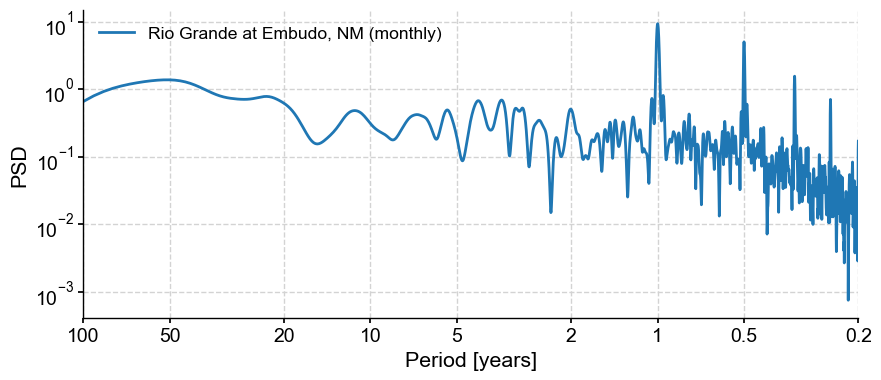

In [226]:
psd_ls = ts.standardize().spectral()
psd_ls.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

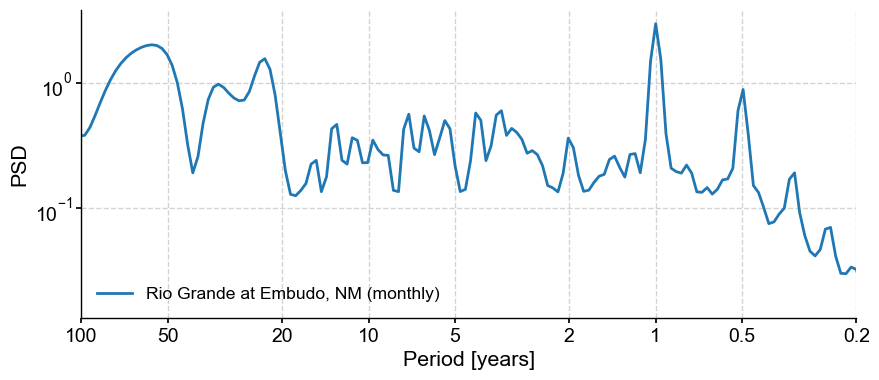

In [227]:
psd_wwz = ts.standardize().spectral(method='wwz')
psd_wwz.plot()

Let's plot all those spectra on the same figure:

<Axes: xlabel='Period [years]', ylabel='PSD'>

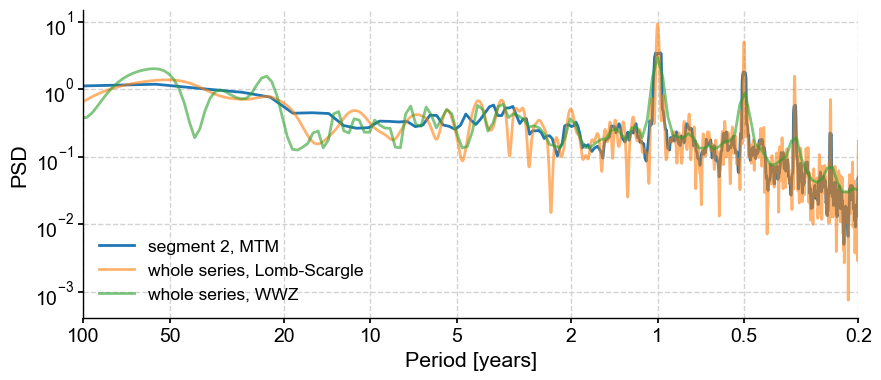

In [241]:
fig, ax = psd_mtm.plot(label='segment 2, MTM')
psd_ls.plot(ax=ax,label='whole series, Lomb-Scargle',alpha=0.6)
psd_wwz.plot(ax=ax,label='whole series, WWZ',alpha=0.6)

It is often useful to be able to compare methods and/or parameter choices, to see if the results are robust. We see that some choices lump peaks into broad bands, others tend to slice them up. 

## FAILED SSA attempt

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

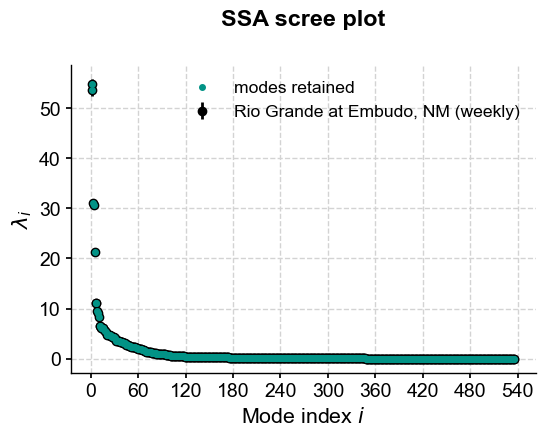

In [82]:
ssa = 
ssa.screeplot()

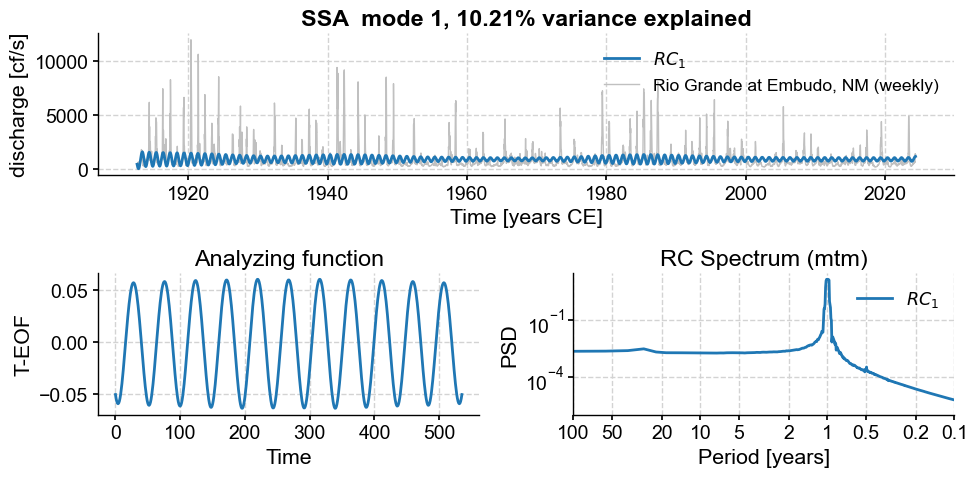

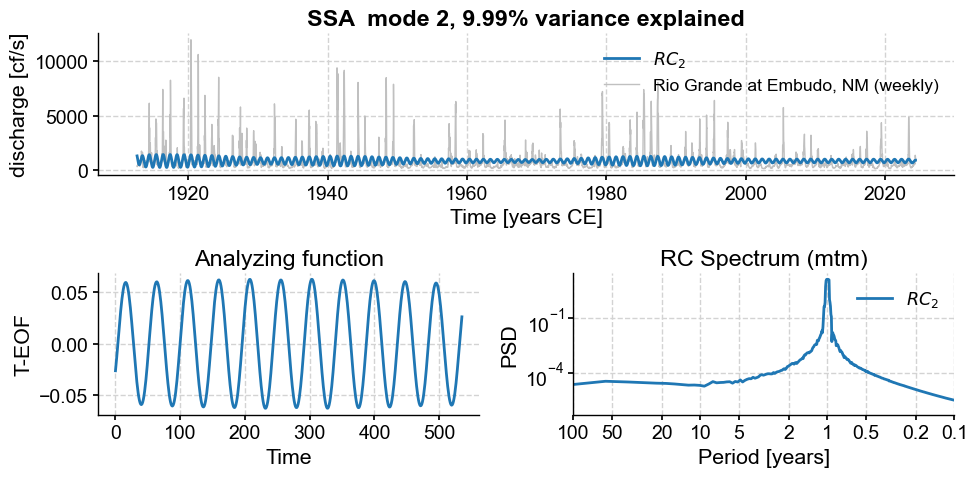

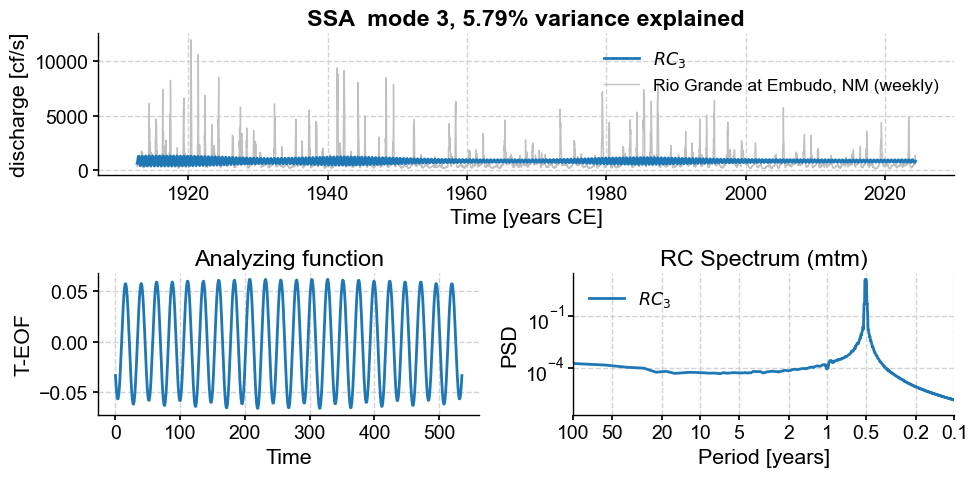

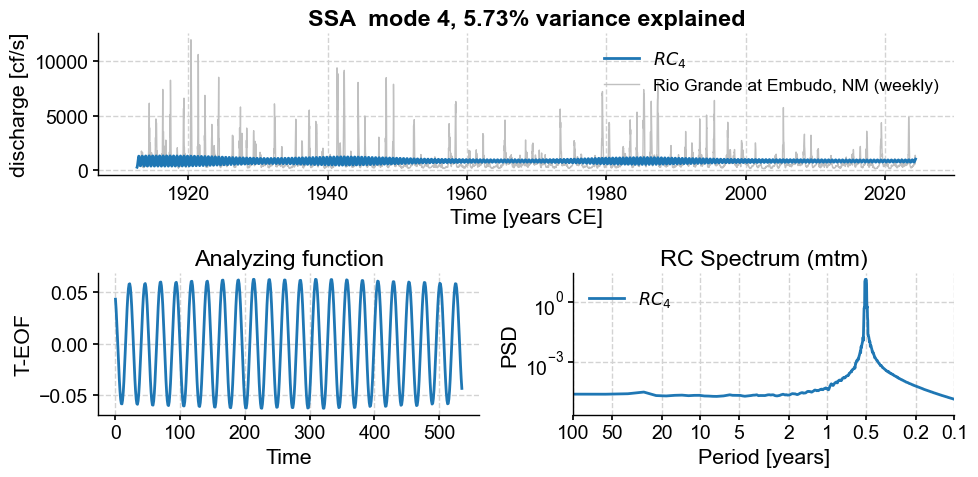

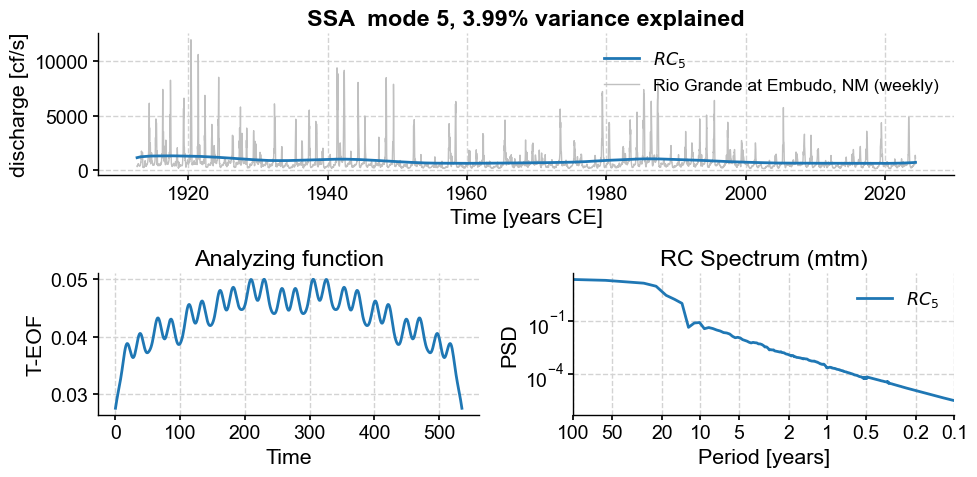

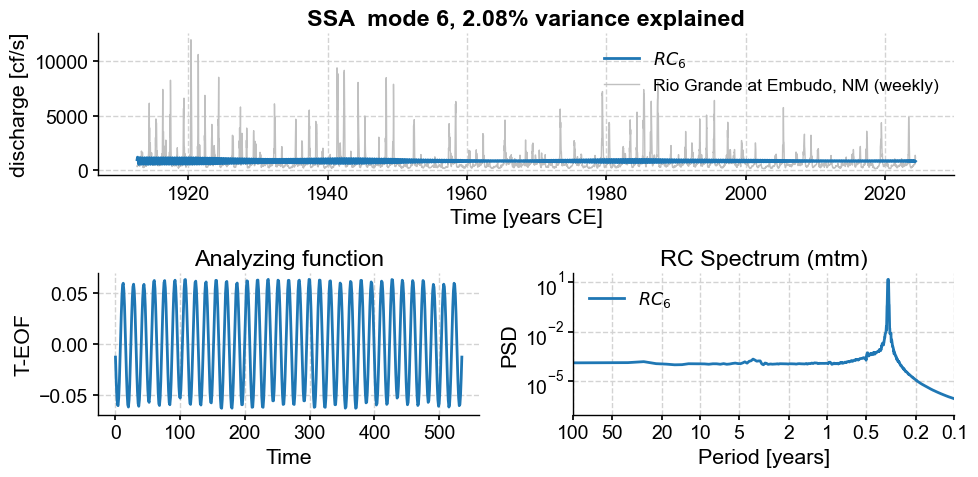

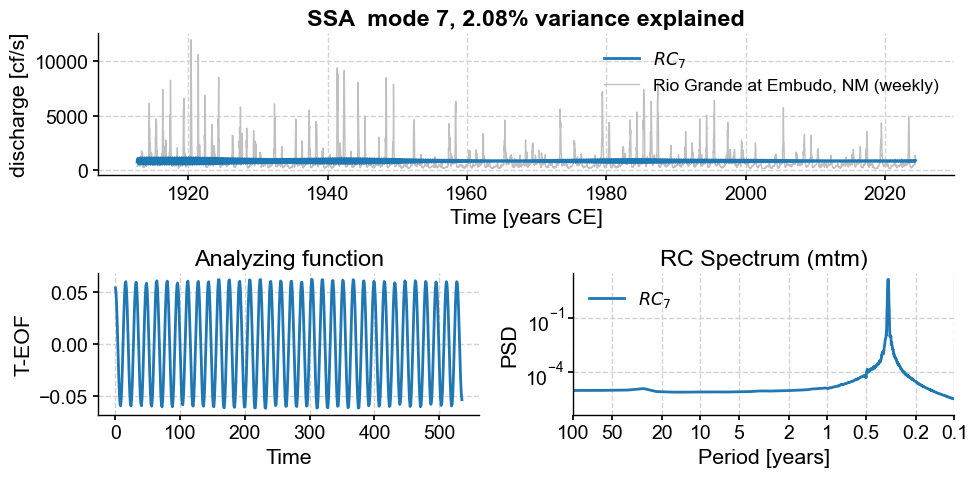

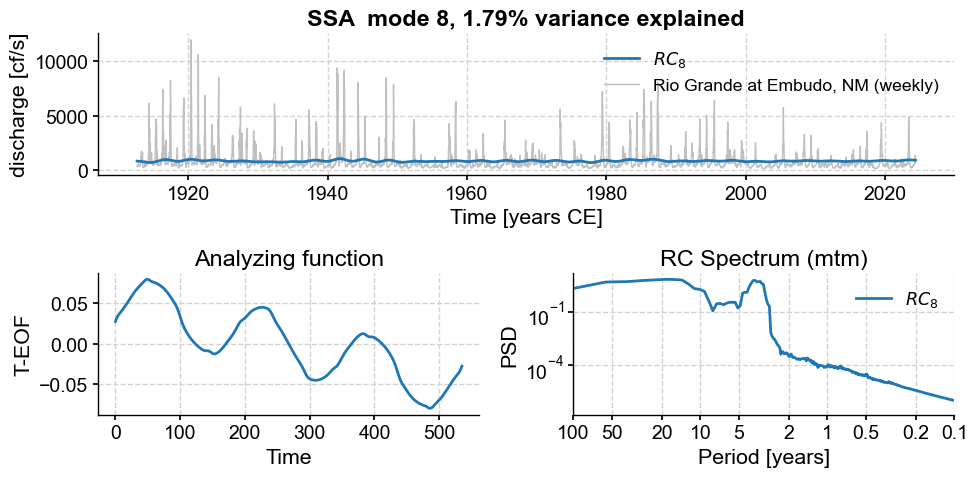

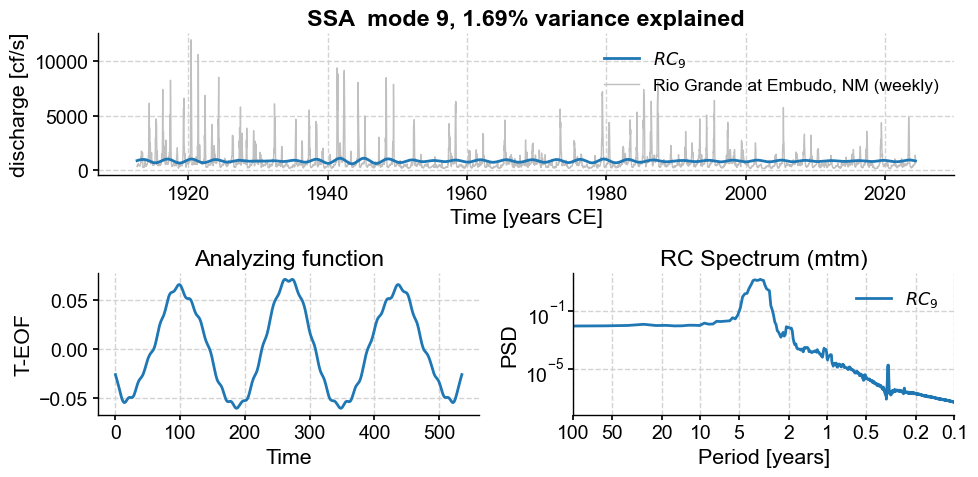

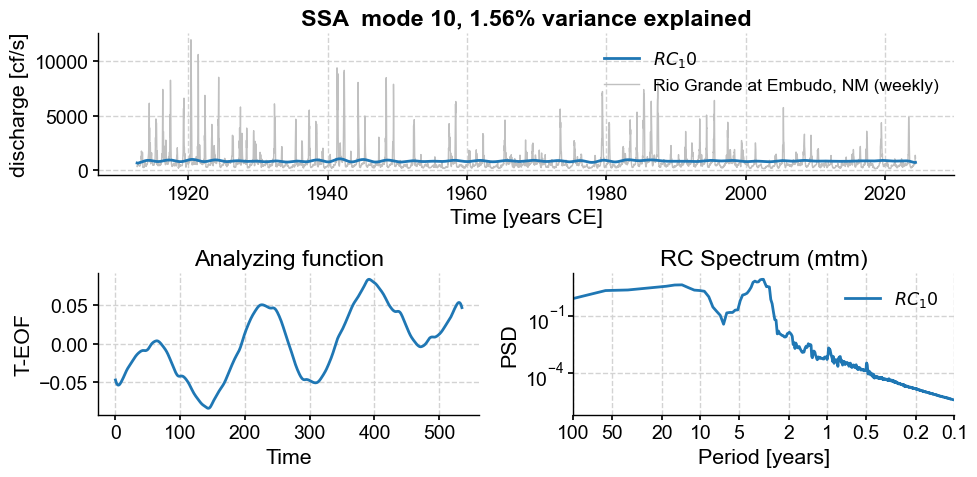

In [83]:
for i in range(10):
    ssa.modeplot(index=i)


Subannual modes identified by SSA:  

In [89]:
subannual_modes = [0, 1 ,2, 3, 5, 6]
M = ssa.RCmat.shape[1] # number of modes
modes2keep = [i for i in range(M) if i not in subannual_modes] # generate list of modes by list comprehension and range constructor
modes2keep

[4,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,


In [92]:
ts_rc = ts_lwc.copy()
ts_rc.value = ssa.RCmat[:,modes2keep].sum(axis=1)

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='discharge [cf/s]'>)

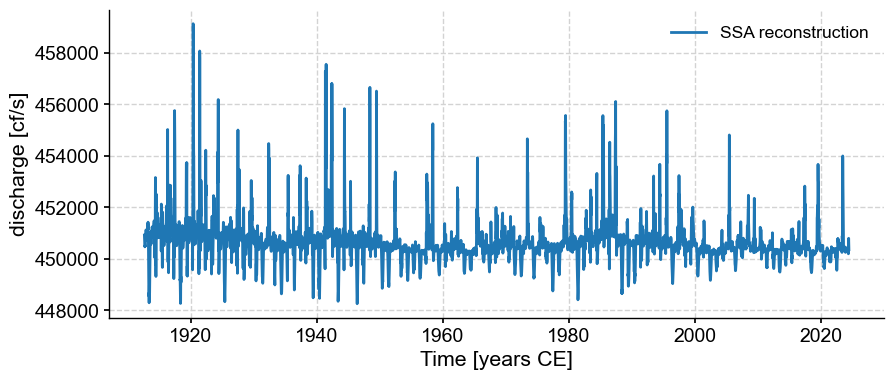

In [94]:
ts_rc.plot(label='SSA reconstruction')
